In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from spectral_metric.estimator import CumulativeGradientEstimator
from spectral_metric.visualize import make_graph

In [3]:
# Lectura de dataset

data_dir = ('CIFAR-10-only train')
data_dir = pathlib.Path(data_dir)

# Lectura de la carpeta train
data_dir_train = ('CIFAR-10-only train/train-corrupted-defocus-blur')
data_dir_train = pathlib.Path(data_dir_train)



image_count_train = len(list(data_dir_train.glob('*/*.png')))  # Cuenta la cantidad de imagenes de train


print(f"Cantidad de imagenes de train: {image_count_train}")

Cantidad de imagenes de train: 100000


In [4]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = image_count_train

In [5]:
# PARA TRABAJAR CON LAS 20 CLASES, TOMAR LAS CARPETAS DE TEST Y LLEVARLAS A TRAIN (RENOMBRANDOLAS)

import tensorflow as tf
import pathlib

# Data splitting (entrenamiento y validación)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100000 files belonging to 20 classes.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")

Número de clases: 20
Los nombres de las clases son: ['airplane', 'airplane_c_defocus_blur', 'automobile', 'automobile_c_defocus_blur', 'bird', 'bird_c_defocus_blur', 'cat', 'cat_c_defocus_blur', 'deer', 'deer_c_defocus_blur', 'dog', 'dog_c_defocus_blur', 'frog', 'frog_c_defocus_blur', 'horse', 'horse_c_defocus_blur', 'ship', 'ship_c_defocus_blur', 'truck', 'truck_c_defocus_blur']


In [7]:
for images, labels0 in train_ds.take(1):  # only take first element of dataset
    x_train = images.numpy()
    y_train = labels0.numpy()

x_train /= 255.0  # Scale the features to the [0, 1] range
#x_train = x_train.reshape(len(x_train), 1, 256, 256)  # reshape into [N, C, H, W] for PyTorch
print(x_train.shape)

(100000, 32, 32, 3)


c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\Desktop\Proyecto-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
c:\Users\Cesar\Desktop\Proyecto-CSG\1 - prueba de CSG\Pruebas en distintos datasets\spectral_metric\visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


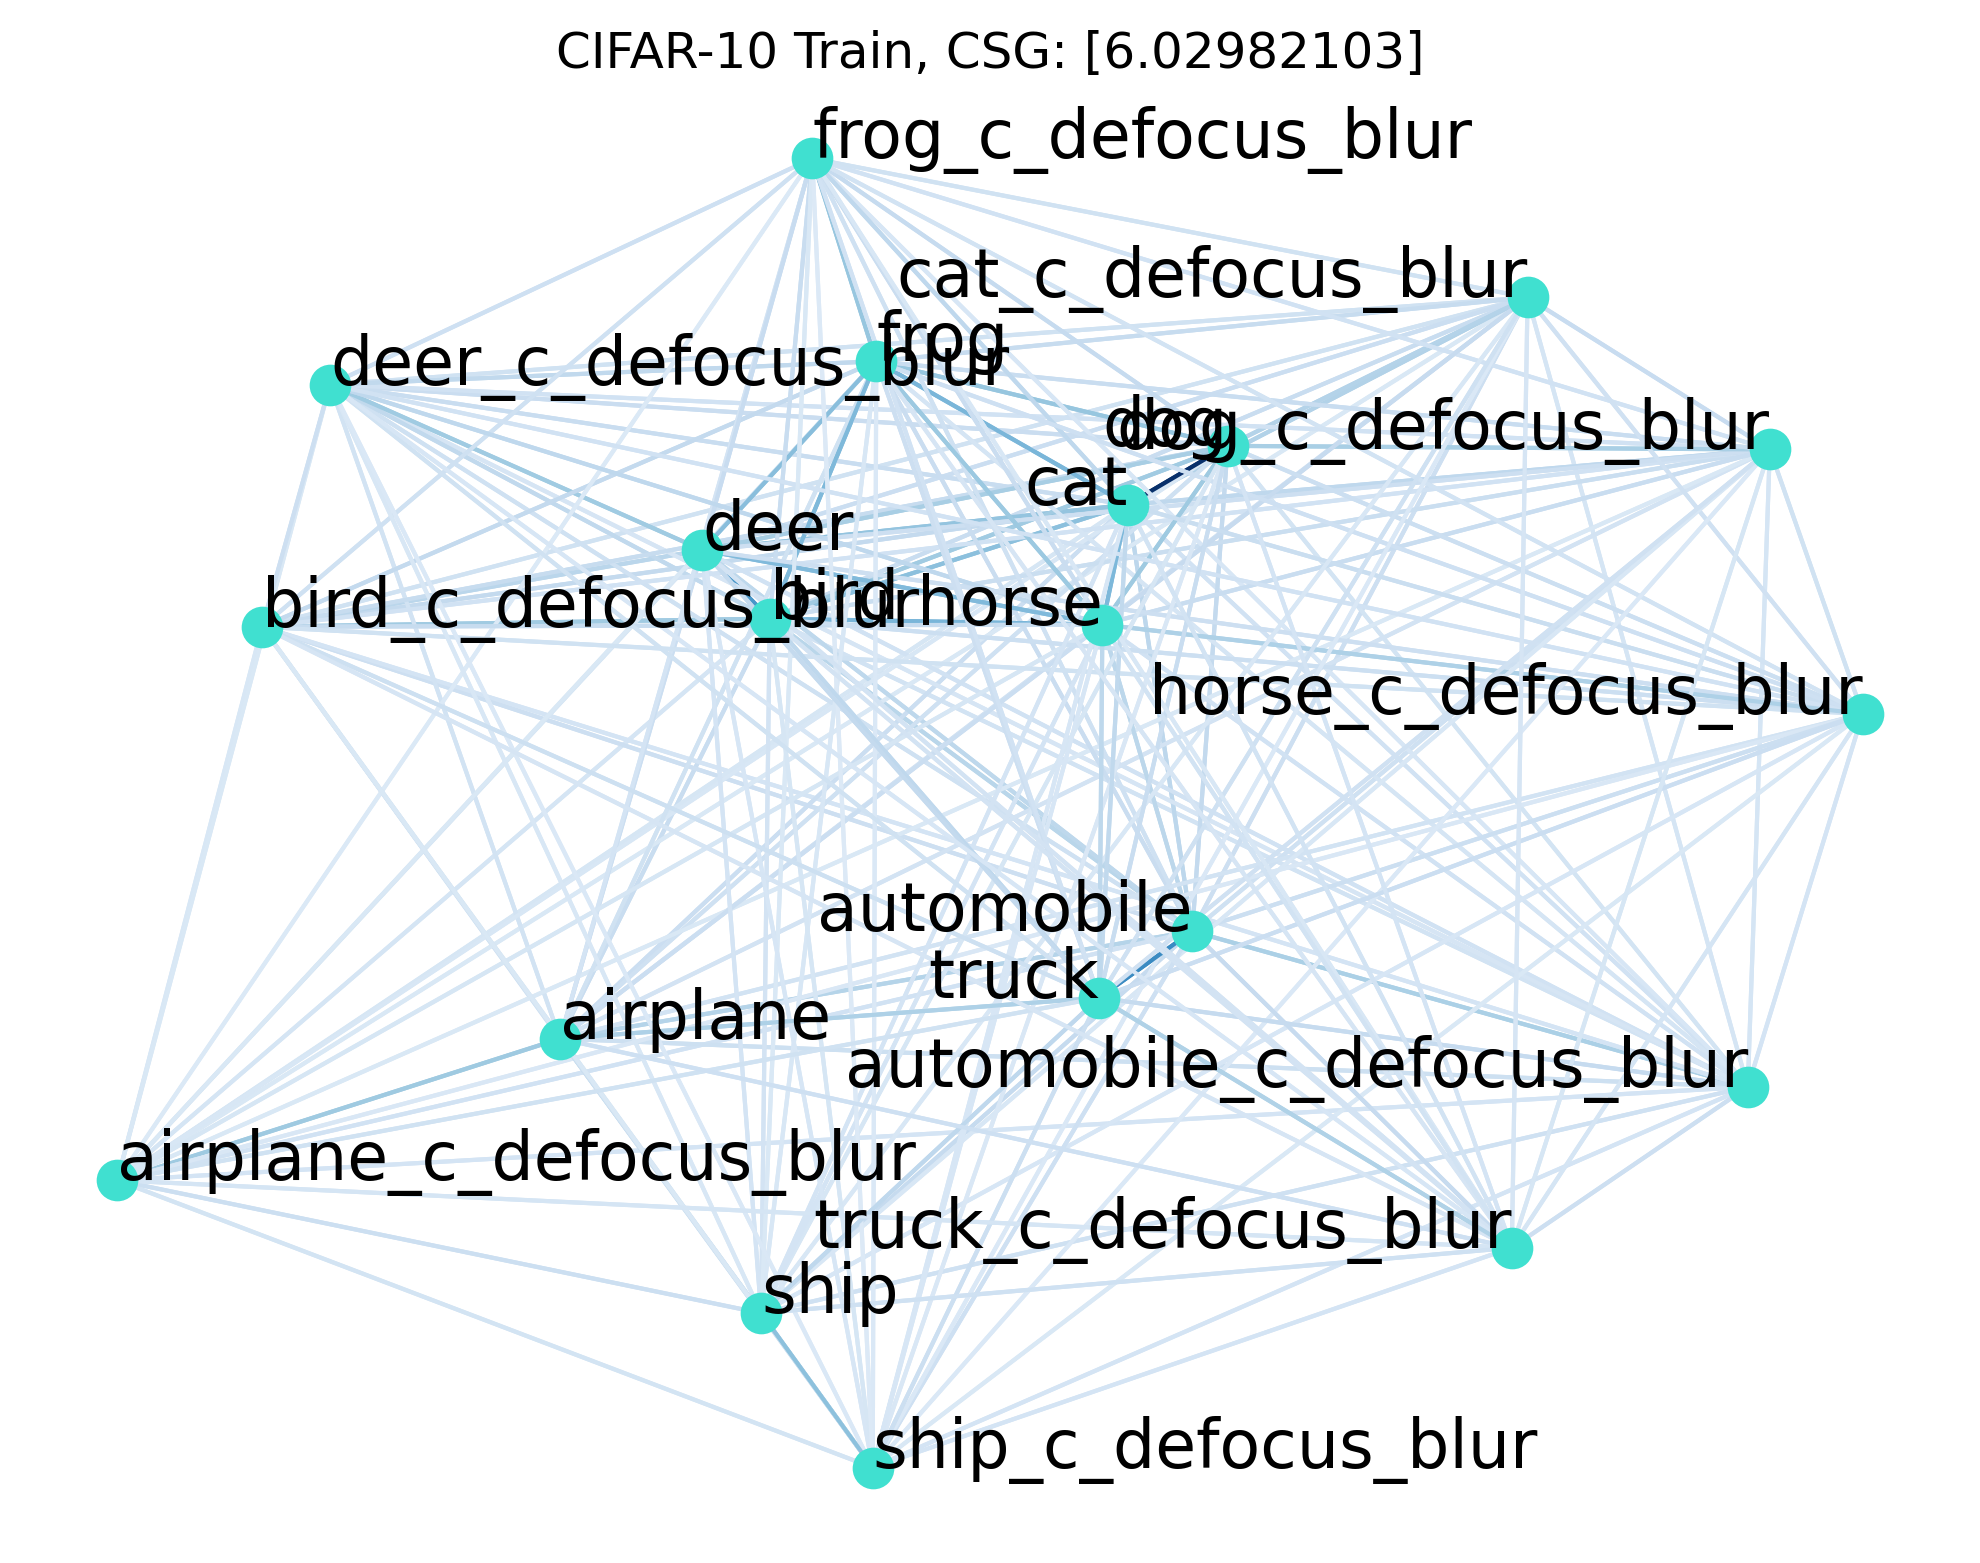

In [8]:
# CIFAR-10 TRAIN SET
X = x_train.reshape( (x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3]))
y = y_train.reshape(y_train.shape[0],)

estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10)
estimator.fit(data=X, target=y)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="CIFAR-10 Train, CSG: "+str(csg), classes=class_names)

In [18]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(i,j) for i,j in pairs if i != j]

least_similar_pair = pairs[0]
i, j = least_similar_pair  # Pares de clases menos similares

print("Least similar pairs")
lst = []
for idx, (i,j) in enumerate(pairs[::2][:1]):
    lst.append({"Intent pair" : f"{class_names[i]} <> {class_names[j]}", "Similarity": estimator.W[i,j]})
print(pd.DataFrame(lst))



Least similar pairs
                                  Intent pair  Similarity
0  frog_c_defocus_blur <> ship_c_defocus_blur      0.1908


In [19]:
class_i_samples = X[y == i]
class_j_samples = X[y == j]

In [20]:
from scipy.spatial.distance import cdist

# Calcular la matriz de distancias entre las muestras de la clase i y la clase j
dist_matrix_ij = cdist(class_i_samples, class_j_samples)
# Encontrar el índice de las muestras menos similares (la mayor distancia)
max_dist_idx_ij = np.unravel_index(np.argmax(dist_matrix_ij), dist_matrix_ij.shape)

# Muestra de la clase i menos similar a las muestras de la clase j
least_similar_i_to_j = class_i_samples[max_dist_idx_ij[0]]
# Muestra de la clase j menos similar a las muestras de la clase i
least_similar_j_to_i = class_j_samples[max_dist_idx_ij[1]]

In [21]:
# Obtener los nombres de archivo correspondientes
filenames = [f.name for f in data_dir_train.glob('*/*.png')]
class_i_indices = np.where(y == i)[0]
class_j_indices = np.where(y == j)[0]

least_similar_i_to_j_filename = filenames[class_i_indices[max_dist_idx_ij[0]]]
least_similar_j_to_i_filename = filenames[class_j_indices[max_dist_idx_ij[1]]]

In [22]:
# Calcular la distancia de similitud entre las muestras seleccionadas
similarity_value = np.linalg.norm(least_similar_i_to_j - least_similar_j_to_i)

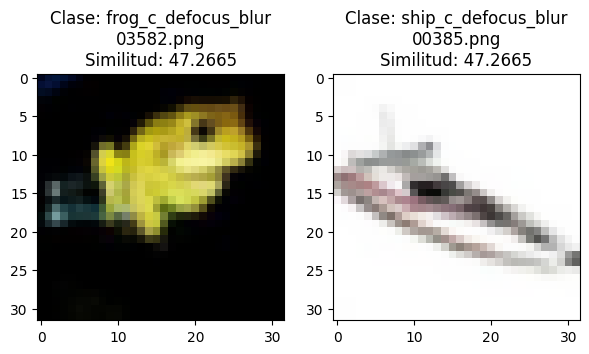

In [23]:
# Visualizar las muestras y la información
least_similar_i_to_j_img = least_similar_i_to_j.reshape(img_height, img_width, 3)
least_similar_j_to_i_img = least_similar_j_to_i.reshape(img_height, img_width, 3)

fig, axs = plt.subplots(1, 2, figsize=(7, 5))
axs[0].imshow(least_similar_i_to_j_img)
axs[0].set_title(f'Clase: {class_names[i]}\n{least_similar_i_to_j_filename}\nSimilitud: {similarity_value:.4f}')
axs[1].imshow(least_similar_j_to_i_img)
axs[1].set_title(f'Clase: {class_names[j]}\n{least_similar_j_to_i_filename}\nSimilitud: {similarity_value:.4f}')
# Entre mayor sea el valor de similitud significa que son menos similares (mas lejanas)
plt.show()